In [47]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# 패키지

In [ ]:
import numpy as np
from tqdm import tqdm
from glob import glob
import os
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf
import gc

**GPU로 실행**

In [ ]:
from tensorflow import keras
keras.__version__

'2.5.0'

# 데이터

In [ ]:
default_path='/content/drive/MyDrive/DACON/'

In [ ]:
train = pd.read_csv(default_path+'weekly_train.csv', parse_dates = ['week_start'])
public_test = pd.read_csv(default_path+'public_weekly_test.csv', parse_dates = ['week_start'])
private_test = pd.read_csv(default_path+'private_weekly_test.csv', parse_dates = ['week_start'])

In [ ]:
for i in range(476, 481):
  train.loc[i, 'week_file_nm'] = train.loc[i-52, 'week_file_nm']
  train.loc[i, 'data_list'] = train.loc[i-52, 'data_list']

In [ ]:
train.head()

,week_start,week_file_nm,data_list
0,1978-10-23,10000.npy,"19781026.npy,19781028.npy"
1,1978-10-30,10001.npy,"19781030.npy,19781101.npy,19781103.npy,1978110..."
2,1978-11-06,10002.npy,"19781107.npy,19781109.npy,19781111.npy"
3,1978-11-13,10003.npy,"19781113.npy,19781115.npy,19781117.npy,1978111..."
4,1978-11-20,10004.npy,"19781121.npy,19781123.npy,19781125.npy"


In [ ]:
public_test.tail()

,week_start,week_file_nm,data_list
19,2020-05-18,12169.npy,"20200518.npy,20200519.npy,20200520.npy,2020052..."
20,2020-05-25,12170.npy,"20200525.npy,20200526.npy,20200527.npy,2020052..."
21,2020-06-01,12171.npy,"20200601.npy,20200602.npy,20200603.npy,2020060..."
22,2020-06-08,12172.npy,"20200608.npy,20200609.npy,20200610.npy,2020061..."
23,2020-06-15,12173.npy,"20200615.npy,20200616.npy,20200617.npy,2020061..."


# 시각화 & 전처리

최근 약 30년(52주 * 30년) 주별 데이터만을 사용하였습니다.

In [ ]:
train_data_path = '/content/drive/MyDrive/DACON/weekly_train_npy/'+train['week_file_nm'].values  # 최근 약 5년(52주 * 5년) 주별 데이터만
# train_data_path = 'data/weekly_train/'+train.tail(52*30)['week_file_nm'].values

In [ ]:
sample = np.load(train_data_path[-1])

각 파일은 해빙 농도(0~250), 북극점(위성 관측 불가 영역), 해안선 마스크, 육지 마스크, 결측값 5개 채널의 배열로 구성되어있습니다.

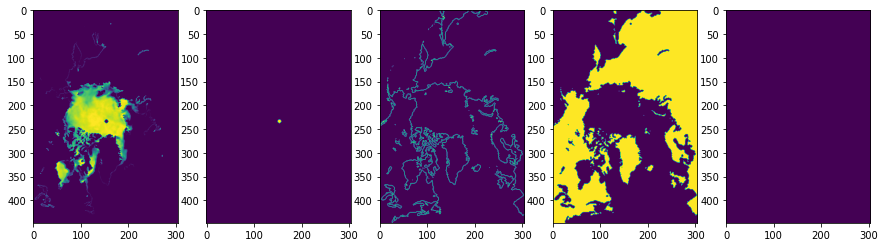

In [ ]:
plt.figure(figsize=(15,5))
for c in range(sample.shape[-1]):
    plt.subplot(1,5,c+1)
    plt.imshow(sample[:,:,c])
plt.show()

테스트 활용 가능 마지막 제공 데이터와 맞춰야하는 기간 사이에는 2주의 공백이 있습니다.

과거 12주의 해빙 변화를 보고 2주 뒤부터 12주간 의 변화르 예측하는 모델을 만들겠습니다.

In [ ]:
input_window_size = 15  # 과거 15주의 해빙 변화를 보고 
target_window_size = 12  # 12주간의 변화를 예측하는
gap = 2  # 2주의 공백
step = 1
input_data_list, target_data_list = [], []

for i in range(0, len(train_data_path) - input_window_size - target_window_size - gap + 1, step):
    input_data = train_data_path[i:i+input_window_size]
    target_data = train_data_path[i+input_window_size+gap:i+input_window_size+gap+target_window_size]
    input_data_list.append(input_data)
    target_data_list.append(target_data)

In [ ]:
input_data_list[-1]

array(['/content/drive/MyDrive/DACON/weekly_train_npy/12145.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12146.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12147.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12148.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12149.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12150.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12151.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12152.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12153.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12154.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12155.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12156.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12157.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12158.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12159.npy'],
      dty

In [ ]:
target_data_list[-1]

array(['/content/drive/MyDrive/DACON/weekly_train_npy/12162.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12163.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12164.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12165.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12166.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12167.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12168.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12169.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12170.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12171.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12172.npy',
       '/content/drive/MyDrive/DACON/weekly_train_npy/12173.npy'],
      dtype=object)

*이미지를 n등분하여 각각 따로 훈련/예측하는 방법 고려*

## 데이터셋

학습과 검증용 데이터로 분리합니다.

최근 1년(52주)을 검증 데이터셋으로 사용하였습니다.

In [ ]:
def train_map_func(x_list, y_list):
    train_x, train_y = [], []
    for path in x_list:
        train_x.append(np.load(path)[:,:,0:1])  # 해빙 농도 정보만
    for path in y_list:
        train_y.append(np.load(path)[:,:,0:1])  # 해빙 농도 정보만
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    
    train_x = train_x.astype(np.float32)/250
    train_y = train_y.astype(np.float32)/250
    return train_x, train_y

In [ ]:
BATCH_SIZE = 2

*배치 사이즈: 학습률 예열을 사용해 큰 배치 사이즈를 시도해보고 훈련이 불안정하거나 최종 성능이 만족스럽지 못하면 작은 배치 크기(2~32)를 사용한다.*

*tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성합니다. 예를 들어 MNIST의 학습데이터 (60000, 28, 28)가 입력되면, 60000개의 slices로 만들고 각각의 slice는 28×28의 이미지 크기를 갖게 됩니다.*

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_data_list[:-52], target_data_list[:-52]))  # 최근 1년(52주)을 검증 데이터셋으로 사용
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)  # 각 아이템에 위의 변환을 적용할 때 여러 스레드로 나누어 속도를 높임
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # 훈련 알고리즘이 한 배치로 작업을 하는 동안 이 데이터셋이 동시에 다음 배치를 준비

val_dataset = tf.data.Dataset.from_tensor_slices((input_data_list[-52:], target_data_list[-52:]))  # 최근 1년(52주)을 검증 데이터셋으로 사용
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), 
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape
# 배치 사이즈, (train_x, train_y, valid_x, valid_y 포함 주 수), 픽셀...

In [ ]:
for item in train_dataset.take(1):
    print(len(item))
    print(type(item))
    print(item)

2
<class 'tuple'>
(<tf.Tensor: shape=(2, 15, 448, 304, 1), dtype=float32, numpy=
array([[[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         ...,

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

# 모델

ConvLSTMCell을 이용하여 Seq2Seq모델을 만들었습니다.

## ConvLSTMCell

*tf.keras.layers.Conv2D에서 정확한 하이퍼파라미터 값을 찾으려면 교차 검증을 사용해야 하지만 시간이 많이 걸린다. 메모리 부족으로 훈련이 실패한다면 미니배치 크기를 줄이거나 스트라이드를 사용해 차원을 줄이거나 몇 개의 층을 제거할 수 있다. 아니면 여러 장치에 CNN을 분산시킬 수 있다.*

*2D -> Pooling(공간 방향 차원 축소) -> 2D -> Pooling -> ..(반복).. -> Dense(완전 연결 네트워크)*

In [ ]:
class ConvLSTMCell(tf.keras.Model):

    def __init__(self, hidden_dim, kernel_size, bias):  # hidden_dim, kernel_size, bias
        super(ConvLSTMCell, self).__init__()

        self.hidden_dim = hidden_dim 
        
        self.kernel_size = kernel_size 
        self.bias = bias
        
        self.conv = tf.keras.layers.Conv2D(  # 각 층이 2D로 표현되는 합성곱 신경망
            filters = 4 * self.hidden_dim,  # 필터 수
            kernel_size = self.kernel_size,  # 각 필터의 높이와 너비
            padding = 'same',  # 제로 패딩. 출력 크기는 입력 뉴련 수를 스트라이드로 나누어올림한 것과 같음. stride=1이면 층의 출력이 입력과 동일한 공간 방향 차원을 가짐.
            use_bias = self.bias  # 편향 
        )
        
    def call(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = tf.concat([input_tensor, h_cur], axis=3)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = tf.split(combined_conv, num_or_size_splits=4, axis=-1)
        i = tf.keras.activations.sigmoid(cc_i)
        f = tf.keras.activations.sigmoid(cc_f)
        o = tf.keras.activations.sigmoid(cc_o)
        g = tf.keras.activations.tanh(cc_g)
        
        c_next = f * c_cur + i * g
        h_next = o*tf.keras.activations.tanh(c_next)
        
        return h_next, c_next
        
    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (tf.zeros([batch_size, height, width, self.hidden_dim]),
                tf.zeros([batch_size, height, width, self.hidden_dim]))

## Encoder

*시퀀스-투-벡터*

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden, enc_num_layers=1):
        super(Encoder, self).__init__()
        self.enc_num_layers = enc_num_layers
        self.encoder_input_convlstm = ConvLSTMCell(
            hidden_dim=hidden,
            kernel_size=(3, 3),
            bias=True
        )
        if self.enc_num_layers is not None:
            self.hidden_encoder_layers = [
                ConvLSTMCell(
                    hidden_dim=hidden,
                    kernel_size=(3, 3),
                    bias=True
                ) for _ in range(self.enc_num_layers)
            ]
        
    def call(self, enc_input):
        h_t, c_t = self.init_hidden(enc_input, 'seq')
        if self.enc_num_layers is not None:
            hidden_h_t = []
            hidden_c_t = []
            for i in range(self.enc_num_layers):
                hidden_h_t += [self.init_hidden(h_t, i)[0]]
                hidden_c_t += [self.init_hidden(h_t, i)[1]]
        
        seq_len = enc_input.shape[1]
        for t in range(seq_len):
            h_t, c_t = self.encoder_input_convlstm(
                input_tensor=enc_input[:, t, :, :, :],
                cur_state=[h_t, c_t]
            )
            input_tensor = h_t
            if self.enc_num_layers is not None:
                for i in range(self.enc_num_layers):
                    hidden_h_t[i], hidden_c_t[i] = self.hidden_encoder_layers[i](
                        input_tensor=input_tensor,
                        cur_state=[hidden_h_t[i], hidden_c_t[i]]
                    )
                    input_tensor = hidden_h_t[i]
        
        if self.enc_num_layers is not None:
            return hidden_h_t[-1], hidden_c_t[-1]
        else:
            return h_t, c_t
    
    def init_hidden(self, input_tensor, seq):
        if seq == 'seq':
            b, seq_len, h, w, _ = input_tensor.shape
            h_t, c_t = self.encoder_input_convlstm.init_hidden(
                batch_size=b,
                image_size=(h, w)
            )
        else:
            b, h, w, _ = input_tensor.shape
            h_t, c_t = self.hidden_encoder_layers[seq].init_hidden(
                batch_size=b,
                image_size=(h, w)
            )
        return h_t, c_t

In [ ]:
sample_enc_input_data = next(iter(train_dataset))[0]
sample_encoder = Encoder(16, 1)
enc_output = sample_encoder(sample_enc_input_data)
enc_output[0].shape, enc_output[1].shape

(TensorShape([2, 448, 304, 16]), TensorShape([2, 448, 304, 16]))

## Decoder

*벡터-투-시퀀스*

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, hidden, dec_num_layers=1, future_len=12):
        super(Decoder, self).__init__()
        self.dec_num_layers = dec_num_layers
        self.future_len = future_len
        self.decoder_input_convlstm = ConvLSTMCell(
            hidden_dim=hidden,
            kernel_size=(3, 3),
            bias=True
        )
        if self.dec_num_layers is not None:
            self.hidden_decoder_layers = [
                ConvLSTMCell(
                    hidden_dim=hidden,
                    kernel_size=(3, 3),
                    bias=True
                ) for _ in range(dec_num_layers)
            ]
        
        self.decoder_output_layer = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=(3,3),
            padding='same',
            activation='sigmoid'
        )
        
    def call(self, enc_output):
        if self.dec_num_layers is not None:
            hidden_h_t = []
            hidden_c_t = []
            for i in range(self.dec_num_layers):
                hidden_h_t += [self.init_hidden(enc_output[0], i)[0]]
                hidden_c_t += [self.init_hidden(enc_output[0], i)[1]]
                
        outputs = []
        input_tensor = enc_output[0]
        h_t, c_t = self.init_hidden(input_tensor, 'seq')
        for t in range(self.future_len):
            h_t, c_t=self.decoder_input_convlstm(
                input_tensor=input_tensor,
                cur_state=[h_t, c_t]
            )
            input_tensor = h_t
            if self.dec_num_layers is not None:
                for i in range(self.dec_num_layers):
                    hidden_h_t[i], hidden_c_t[i] = self.hidden_decoder_layers[i](
                        input_tensor=input_tensor,
                        cur_state=[hidden_h_t[i], hidden_c_t[i]]
                    )
                    input_tensor=hidden_h_t[i]
                output = self.decoder_output_layer(hidden_h_t[-1])
            else:
                output = self.decoder_output_layer(h_t)
            outputs += [output]
        outputs = tf.stack(outputs, 1)
        
        return outputs
    
    def init_hidden(self, input_tensor, seq):
        if seq == 'seq':
            b, h, w, _ = input_tensor.shape
            h_t, c_t = self.decoder_input_convlstm.init_hidden(
                batch_size=b,
                image_size=(h, w)
            )
        else:
            b, h, w, _ = input_tensor.shape
            h_t, c_t = self.hidden_decoder_layers[seq].init_hidden(
                batch_size=b,
                image_size=(h, w)
            )
        return h_t, c_t

In [ ]:
sample_decoder = Decoder(16)
dec_output = sample_decoder(enc_output)
dec_output.shape

TensorShape([2, 12, 448, 304, 1])

## Seq2Seq

Encoder와 Decoder를 연결한 최종 모델입니다.

In [ ]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, hidden, enc_num_layers=1, dec_num_layers=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(hidden, enc_num_layers)
        self.decoder = Decoder(hidden, dec_num_layers)
        
    def call(self, enc_input):
        enc_output = self.encoder(enc_input)
        dec_output = self.decoder(enc_output)
        
        return dec_output

In [ ]:
model = Seq2Seq(16, 1, 1)

## 학습률 & 옵티마이저

In [ ]:
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate)

## 손실 함수

손실함수로 MAE를 사용하였습니다.

In [ ]:
@tf.function
def loss_function(output, target):
    mae_loss = tf.math.reduce_mean(tf.keras.losses.MAE(output, target))
    return mae_loss

## 대회 산식(MAE / F1)

검증용으로 사용하였습니다.

In [ ]:
def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    return score

def f1_score(true, pred):
    target = np.where((true > 0.05) & (true < 0.5))
    
    true = true[target]
    pred = pred[target]
    
    true = np.where(true < 0.15, 0, 1)
    pred = np.where(pred < 0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true + 1e-8)
    recall = right / np.sum(pred + 1e-8)

    score = 2 * precision * recall / (precision + recall + 1e-8)
    
    return score

def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1 + 1e-8)
    
    return score

def val_score(inp, targ):
    output = model(inp)
    score = mae_over_f1(targ.numpy(), output.numpy())
    return score

## 학습 정의

In [ ]:
@tf.function
def train_step(inp, targ, training):
    loss = 0
    with tf.GradientTape() as tape:
        output = model(inp)
        for t in range(targ.shape[1]):
            loss += loss_function(targ[:, t], output[:, t])
            
    batch_loss = (loss / int(targ.shape[1]))
    
    if training==True:
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
    return batch_loss

In [ ]:
gc.collect()

11564

## 체크포인트

In [ ]:
checkpoint_path = '/content/drive/MyDrive/DACON/이유진/123/checkpoint/'
os.makedirs(checkpoint_path, exist_ok=True)
ckpt = tf.train.Checkpoint(
    Seq2Seq=model, 
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(ckpt_manager.latest_checkpoint)

/content/drive/MyDrive/DACON/이유진/123/checkpoint/ckpt-7


## 학습

In [ ]:
EPOCHS = 10
# EPOCHS = 50

loss_plot, val_score_plot = [], []
for epoch in range(EPOCHS):
    total_loss, total_val_score = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataset))
    for (batch, (inp, targ)) in tqdm_dataset:
        batch_loss = train_step(inp, targ, True)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(250*batch_loss.numpy().mean()),
            'Total Loss' : '{:06f}'.format(250*total_loss/(batch+1))
        })
    loss_plot.append(250*total_loss/(batch+1))
    
    tqdm_dataset_val = tqdm(enumerate(val_dataset))
    for (batch, (inp, targ)) in tqdm_dataset_val:
        batch_val_score = val_score(inp, targ)
        total_val_score += batch_val_score.mean()
        
        tqdm_dataset_val.set_postfix({
            'Epoch': epoch + 1,
            'Val Score': '{:06f}'.format(250*batch_val_score.mean()),
            'Val Total_Score' : '{:06f}'.format(250*total_val_score/(batch+1))
        })
    val_score_plot.append(250*total_val_score/(batch+1))
    
    if np.min(val_score_plot) == val_score_plot[-1]:
        ckpt_manager.save()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.



574it [09:10,  1.04it/s, Epoch=10, Loss=6.049957, Total Loss=7.791020]




574it [09:11,  1.04it/s, Epoch=10, Loss=6.518831, Total Loss=7.788808]




575it [09:11,  1.03it/s, Epoch=10, Loss=6.518831, Total Loss=7.788808]




575it [09:12,  1.03it/s, Epoch=10, Loss=7.832461, Total Loss=7.788884]




576it [09:12,  1.03it/s, Epoch=10, Loss=7.832461, Total Loss=7.788884]




576it [09:13,  1.03it/s, Epoch=10, Loss=7.808158, Total Loss=7.788917]




577it [09:13,  1.04it/s, Epoch=10, Loss=7.808158, Total Loss=7.788917]




577it [09:14,  1.04it/s, Epoch=10, Loss=8.050570, Total Loss=7.789369]




578it [09:14,  1.04it/s, Epoch=10, Loss=8.050570, Total Loss=7.789369]




578it [09:15,  1.04it/s, Epoch=10, Loss=8.317219, Total Loss=7.790280]




579it [09:15,  1.03it/s, Epoch=10, Loss=8.317219, Total Loss=7.790280]




579it [09:16,  1.03it/s, Epoch=10, Loss=9.190056, Total Loss=7.792694]




580it [09:16,  1.03it/s, Epoch=10, Loss=9.190056, Total Loss=

In [ ]:
# 8시33분~

## 학습 결과

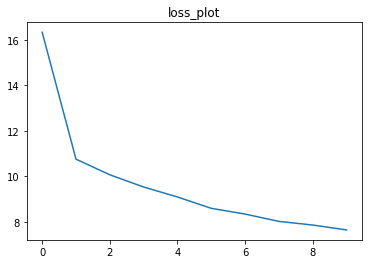

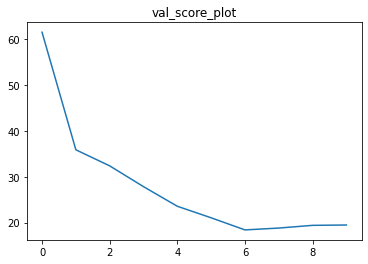

In [ ]:
plt.plot(loss_plot)
plt.title('loss_plot')
plt.show()

plt.plot(val_score_plot)
plt.title('val_score_plot')
plt.show()

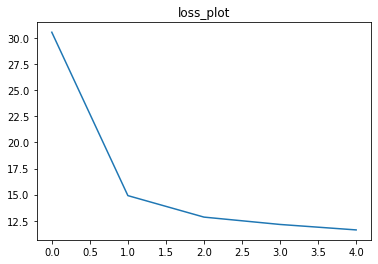

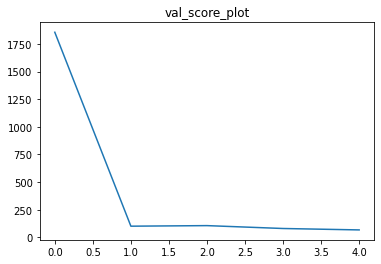

In [ ]:
# plt.plot(loss_plot)
# plt.title('loss_plot')
# plt.show()

# plt.plot(val_score_plot)
# plt.title('val_score_plot')
# plt.show()

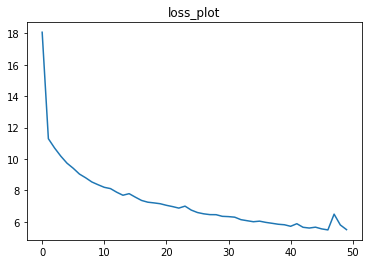

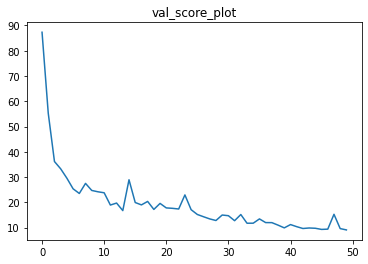

In [ ]:
# plt.plot(loss_plot)
# plt.title('loss_plot')
# plt.show()

# plt.plot(val_score_plot)
# plt.title('val_score_plot')
# plt.show()

## 모델복원

In [ ]:
ckpt.restore(ckpt_manager.latest_checkpoint)

## 추론

In [ ]:
public_test_path = '/content/drive/MyDrive/DACON/weekly_train_npy/'+public_test.tail(12)['week_file_nm']
private_test_path = '/content/drive/MyDrive/DACON/weekly_train_npy/'+private_test.tail(12)['week_file_nm']

In [ ]:
def predict(img_path):
    test_imgs=[]
    for path in img_path:
        test_imgs.append(np.load(path)[:,:,0:1].astype(np.float32)/250)
    test_imgs = np.array([test_imgs])
    enc_input = tf.convert_to_tensor(test_imgs)
    pred = model(enc_input)[0].numpy()*250
    
    return pred

In [ ]:
pred_2020 = predict(public_test_path)

In [ ]:
pred_2020[0].shape

(448, 304, 1)

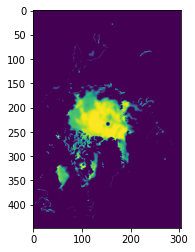

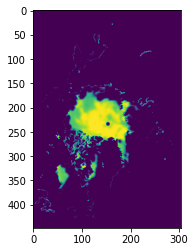

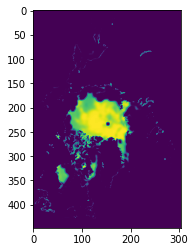

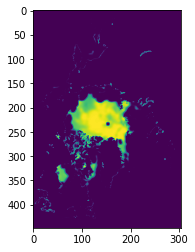

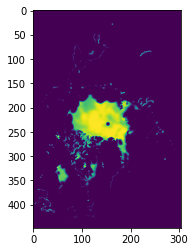

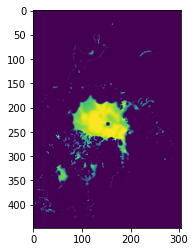

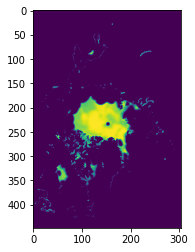

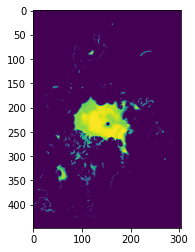

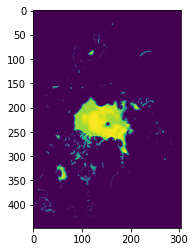

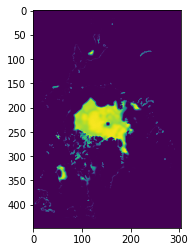

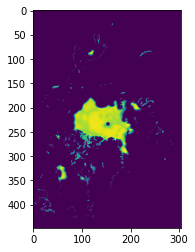

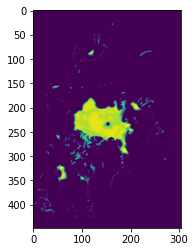

In [ ]:
for i in range(12):
    plt.imshow(pred_2020[i,:,:,0])
    plt.show()

In [ ]:
pred_2021 = predict(private_test_path)

In [ ]:
pred_2021[0].shape

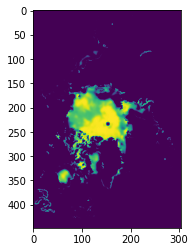

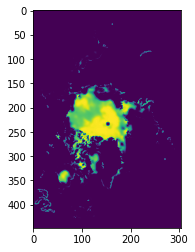

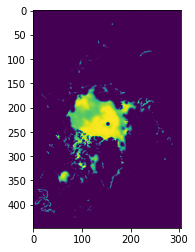

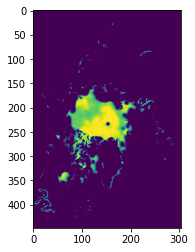

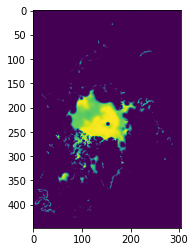

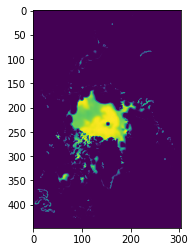

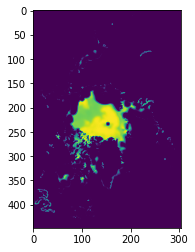

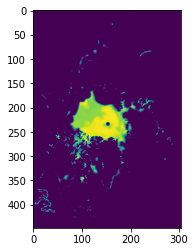

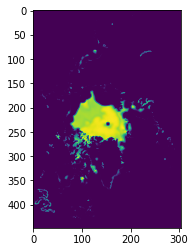

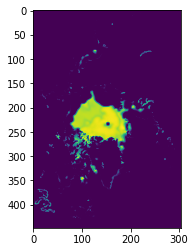

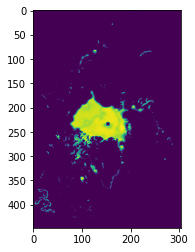

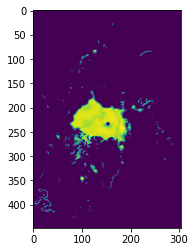

In [ ]:
for i in range(12):
    plt.imshow(pred_2021[i,:,:,0])
    plt.show()

## 제출

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/DACON/sample_submission.csv')

In [ ]:
submission.columns

Index(['week_start', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '136182', '136183', '136184', '136185', '136186', '136187', '136188',
       '136189', '136190', '136191'],
      dtype='object', length=136193)

In [51]:
sub_2020 = submission.loc[:11, ['week_start']].copy()
sub_2021 = submission.loc[12:, ['week_start']].copy().reset_index(drop=True)

sub_2020 = pd.concat([sub_2020, (pd.DataFrame(pred_2020.reshape([12,-1])))], axis=1)
sub_2021 = pd.concat([sub_2021, (pd.DataFrame(pred_2021.reshape([12,-1])))], axis=1)
# sub_2021.columns = sub_2020.columns
submission_ = pd.concat([sub_2020, sub_2021])

In [55]:
submission_.columns = submission.columns.astype(str)

In [56]:
submission_.columns

Index(['week_start', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '136182', '136183', '136184', '136185', '136186', '136187', '136188',
       '136189', '136190', '136191'],
      dtype='object', length=136193)

In [57]:
# submission.drop(index=[10, 11], axis = 0, inplace=True)

In [59]:
submission_.to_csv('/content/drive/MyDrive/DACON/제출_초안7.csv', index=False)

In [58]:
submission_

,week_start,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2020-07-06,4.166379,0.445656,0.296652,0.286140,0.294402,0.294156,0.294529,0.293843,0.292487,0.293367,0.292704,0.293009,0.292890,0.292934,0.292912,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,0.292920,...,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287339,0.287324,0.287287,0.287525,0.287302,0.288218,0.284329,0.296704,0.371173,0.269853,0.196889,0.214644,0.254065,3.687561
1,2020-07-13,0.981167,0.085428,0.059709,0.049584,0.049591,0.049576,0.049427,0.049785,0.049397,0.049762,0.049524,0.049628,0.049599,0.049606,0.049606,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,0.049613,...,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052147,0.052124,0.052124,0.052124,0.052139,0.052132,0.052191,0.052005,0.052489,0.052124,0.050947,0.065684,0.050887,0.036709,0.053100,0.071973,1.455575
2,2020-07-20,0.604928,0.057943,0.041895,0.032276,0.032030,0.032574,0.032037,0.032544,0.032067,0.032410,0.032201,0.032298,0.032261,0.032268,0.032276,0.032254,0.032254,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,0.032268,...,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049464,0.049450,0.049442,0.049517,0.049256,0.049584,0.049911,0.048414,0.059247,0.048466,0.036053,0.052303,0.069588,1.219518
3,2020-07-27,0.489153,0.050314,0.037260,0.027808,0.027714,0.028458,0.027673,0.028196,0.027699,0.028038,0.027839,0.027926,0.027907,0.027906,0.027909,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,0.027908,...,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044413,0.044428,0.044413,0.044510,0.044271,0.044398,0.045151,0.043362,0.051253,0.044890,0.034317,0.051305,0.070013,1.113087
4,2020-08-03,0.443377,0.047565,0.035852,0.025957,0.026033,0.026825,0.025959,0.026497,0.026033,0.026364,0.026187,0.026259,0.026251,0.026244,0.026249,0.026247,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,0.026248,...,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042625,0.042610,0.042610,0.042610,0.042610,0.042625,0.042625,0.042625,0.042632,0.042610,0.042699,0.042476,0.042506,0.043482,0.041544,0.048123,0.

[모델 저장-1](https://financial-engineering.medium.com/%EC%83%88%EB%A1%9C%EC%9A%B4-%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B02-0-%EB%A7%8C%EB%93%A0-%EB%AA%A8%EB%8D%B8%EC%9D%84-%EC%A0%80%EC%9E%A5%ED%95%98%EA%B3%A0-%EB%B6%88%EB%9F%AC%EC%98%A4%EA%B8%B0-5da506b59e13)
[모델 저장-2](http://jaynewho.com/post/8)

In [ ]:
# Save the weights
model.save_weights('/content/drive/MyDrive/DACON/이유진/checkpoints/my_checkpoint')
# #previously, model.save_weights(checkpoint_path.format(epoch=0))
# # Create a new model instance
# model = create_model()

# # Restore the weights
# model.load_weights('/content/drive/MyDrive/DACON/이유진/checkpoints/my_checkpoint')
# #previously, model.load_weights(checkpoint_path) # Evaluate the model
# loss,acc = model.evaluate(test_images, test_labels)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))